# Predicting Stock Price Using LSTM

# Packages

In [1760]:
# Standard
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt

# Utility
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import time

# Neural network
import torch
import torch.nn as nn
from torch import optim

# Import data

In [1761]:
# Import CSV-file
data = pd.read_csv("data.csv")

# Display first 10 rows of data
data.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


# Unique stocks

In [1762]:
# Unique stocks in data
display(data["Name"].unique())

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

# Amazon stock

In [1763]:
amzn = data[data["Name"] == "AMZN"].copy()
amzn.sort_values("date", ascending=True)

,date,open,high,low,close,volume,Name
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN
...,...,...,...,...,...,...,...
47641,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808,AMZN
47642,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722,AMZN
47643,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985,AMZN
47644,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819,AMZN


# Missing data

In [1764]:
amzn.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

# Data information

In [1765]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


# Convert date to datetime64[ns]

In [1766]:
# To datetime
amzn["date"] = pd.to_datetime(amzn["date"])
amzn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


Prepare AMZN stock data

In [1767]:
# Drop Name column
amzn = amzn.drop(columns = ["Name"])

# Shape of amzn stock data

In [1768]:
# Display amzn data
display(amzn)

,date,open,high,low,close,volume
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780
...,...,...,...,...,...,...
47641,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808
47642,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722
47643,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985
47644,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819


# Visualize stock closing price

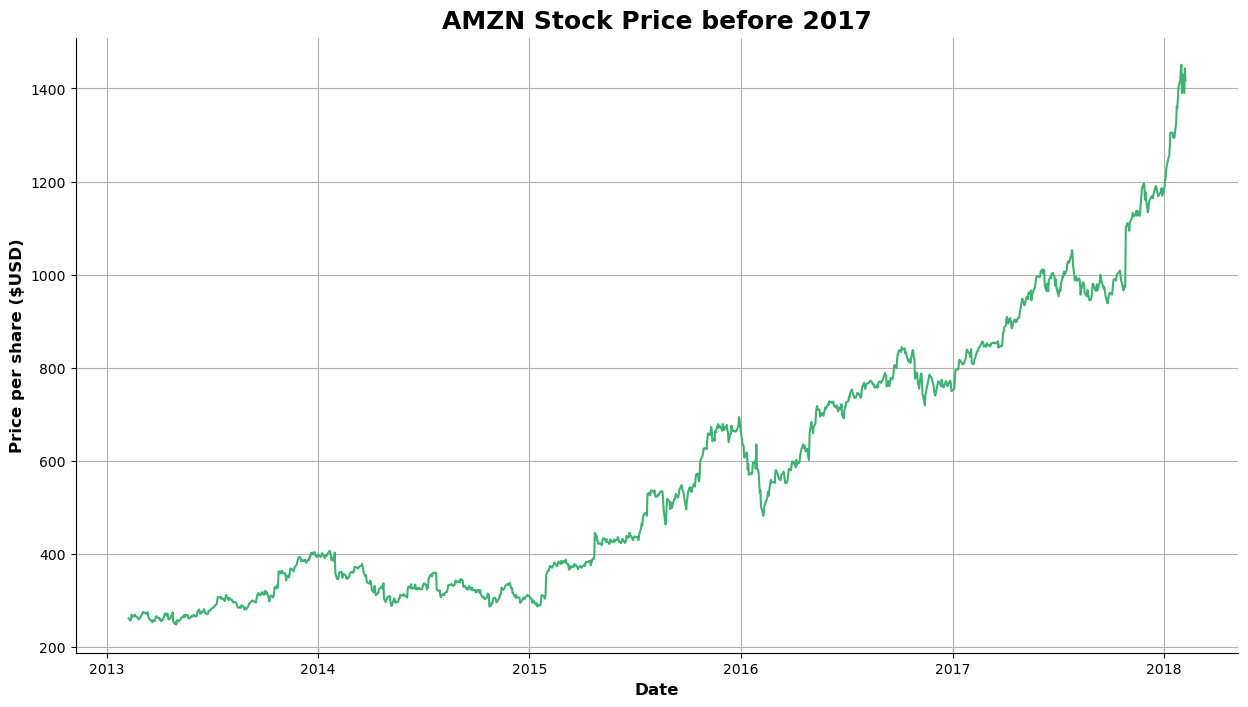

In [1769]:
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(
    amzn["date"], 
    amzn["close"], 
    c = "#3CB371"
    )

# Grid
plt.grid(True)

# Title
plt.title(
    "AMZN Stock Price before 2017", 
    fontweight = "bold", 
    fontsize = 18
    )

# Labels
plt.xlabel(
    "Date",
    fontweight = "bold",
    fontsize = 12
    )
plt.ylabel(
    "Price per share ($USD)",
    fontweight = "bold",
    fontsize = 12
    )

# Spines
ax.spines["top"].set_color("w")
ax.spines["right"].set_color("w")
plt.show()

# Train and test data split

In [1770]:
# Split train and test data (2017)
train = amzn[amzn["date"].dt.year <= 2016].copy()
test = amzn[amzn["date"].dt.year > 2016].copy()

# Convert time

In [1771]:
# Convert date til UNIX time
train["date"] = train["date"].astype(int) // 10 ** 9
test["date"] = test["date"].astype(int) // 10 ** 9

# Scale data

In [1772]:
# Columns
feature_columns = ["date", "open", "high", "low", "volume"]
target_column = "close"

# Scale data with MinMaxScaler()
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Transform feature data
train_features = features_scaler.fit_transform(train[feature_columns])
test_features = features_scaler.transform(test[feature_columns])

# Transform target columns
train_target = target_scaler.fit_transform(train[[target_column]])
test_target = target_scaler.transform(test[[target_column]])

# Create scaled DataFrames

In [1773]:
# Create DataFrame for train with scaled data
train_scaled = pd.DataFrame(train_features, columns=feature_columns)
train_scaled["close"] = train_target

# Create DataFrame for test with scaled data
test_scaled = pd.DataFrame(test_features, columns=feature_columns)
test_scaled["close"] = test_target

# Create sequences (close price is target)

In [1774]:
def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i+seq_length), 0:5]
        # Define target
        y = df.iloc[i+seq_length, 5]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Train and test data to dataloaders

In [1775]:
# Length of sequences
len_sequences = 10

# Create sequences
X_train, y_train = create_sequences(train_scaled, len_sequences)
X_test, y_test = create_sequences(test_scaled, len_sequences)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = False     # Set to false due to date feature
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = False     # Set to false due to date feature
)

# LSTM

In [1776]:
class Net(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = 300,
            num_layers = 3,
            dropout = 0.2,
            batch_first = True
        )

        self.fc1 = nn.Linear(300, 150)
        self.fc2 = nn.Linear(150, 75)
        self.fc3 = nn.Linear(75, 1)

    # Forward pass
    def forward(self, x):
        h0 = torch.zeros(3, x.size(0), 300)
        c0 = torch.zeros(3, x.size(0), 300)
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Define model, loss function, optimizer and metrics

In [1777]:
# Model
net = Net(n_features=5)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.000005, weight_decay=10e-6)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience=3, factor=0.1)

# Define MSE metric
mse = torchmetrics.MeanSquaredError()

# Training and evaluating LSTM

In [1778]:
# Number of epochs
n_epoch = 100

# Losses
train_losses = []
test_losses = []

# Test MSE
mse_list = []

# Storage lists for predicted and actual close price
pred = []
actual_train = []
actual_test = []

# Best predicted and actual close price
best_pred = []
best_actual_train = []
best_actual_test = []

# Early stopping parameters
patience = 5
best_loss = float('inf')
counter = 0
early_stop = False

for epoch in range(n_epoch):
    start_time = time.time()
    train_running_loss = 0.0
    # Train data
    for seqs, labels in train_dataloader:
        # Reshape seqs
        seqs = seqs.view(seqs.size(0), len_sequences, 5)
        
        # Get model outputs
        outputs = net(seqs)
        labels = labels.view(-1, 1)

        # Save actual close prices from train data
        actual_train.extend(labels.cpu().numpy())
        
        # Compute loss
        train_loss = criterion(outputs, labels)
        train_running_loss += train_loss.item()

        # Back propagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    # Epoch train performance
    train_run_loss = train_running_loss / len(train_dataloader)
    train_losses.append(train_run_loss)

    # Test data
    net.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        for seqs, labels in test_dataloader:
            seqs = seqs.view(seqs.size(0), len_sequences, 5)
            
            # Pass seqs to net and squeeze the result
            outputs = net(seqs).squeeze()
            mse(outputs, labels)

            # Save actual and predicted close prices from test data
            actual_test.extend(labels.cpu().numpy())
            pred.extend(outputs.cpu().numpy())

            # Compute loss
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()
    
    # Epoch test performance
    test_run_loss = test_running_loss / len(test_dataloader)
    test_losses.append(test_run_loss)

    # Early stop and save best results + model
    if test_run_loss < best_loss:
        best_loss = test_run_loss
        counter = 0

        # Save best results
        best_pred = pred
        best_actual_train = actual_train
        best_actual_test = actual_test

        # Empty lists for next epoch
        pred = []
        actual_train = []
        actual_test = []

        # Save best model:
        model = torch.save(net, "LSTM_AMZN_stock.pth")
    else:
        counter += 1

        # Empty storage lists for next epoch
        pred = []
        actual_train = []
        actual_test = []   

        # Initialise early stop
        if counter >= patience:
            early_stop = True

    # Update learning rate based on test_run_loss
    scheduler.step(metrics=test_run_loss)

    # Compute MSE value
    test_mse = mse.compute()
    mse_list.append(test_mse)

    # Epoce finish time
    finish_time = time.time()

    # Epoch summary
    print(f"Epoch {epoch+1} \nTrain loss: {train_loss.item():.4f} | Test loss: {test_loss.item():.4f}\nTest MSE: {test_mse:.4f} | Epoch time: {finish_time-start_time:.03f}s\nTest loss patience: {counter} of {patience}\n")

    # Break if early stop is True
    if early_stop:
        print(f'EARLY STOP!')
        break

    # Switch to train
    net.train()

Epoch 1 
Train loss: 0.9243 | Test loss: 4.1738
Test MSE: 1.9387 | Epoch time: 0.467s
Test loss patience: 0 of 5

Epoch 2 
Train loss: 0.9003 | Test loss: 4.1233
Test MSE: 1.9220 | Epoch time: 0.499s
Test loss patience: 0 of 5

Epoch 3 
Train loss: 0.8779 | Test loss: 4.0735
Test MSE: 1.9055 | Epoch time: 0.478s
Test loss patience: 0 of 5

Epoch 4 
Train loss: 0.8545 | Test loss: 4.0221
Test MSE: 1.8889 | Epoch time: 0.449s
Test loss patience: 0 of 5

Epoch 5 
Train loss: 0.8319 | Test loss: 3.9672
Test MSE: 1.8717 | Epoch time: 0.451s
Test loss patience: 0 of 5

Epoch 6 
Train loss: 0.8047 | Test loss: 3.9070
Test MSE: 1.8539 | Epoch time: 0.446s
Test loss patience: 0 of 5

Epoch 7 
Train loss: 0.7769 | Test loss: 3.8389
Test MSE: 1.8349 | Epoch time: 0.443s
Test loss patience: 0 of 5

Epoch 8 
Train loss: 0.7436 | Test loss: 3.7600
Test MSE: 1.8145 | Epoch time: 0.440s
Test loss patience: 0 of 5

Epoch 9 
Train loss: 0.7069 | Test loss: 3.6662
Test MSE: 1.7921 | Epoch time: 0.455s
Te

# Visualize train and test loss

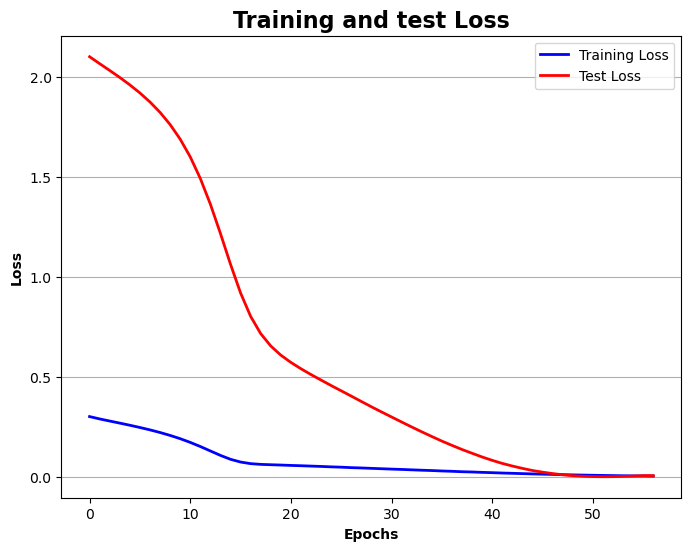

In [1779]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", linewidth = 2, c = "b")
plt.plot(test_losses, label="Test Loss", linewidth = 2, c = "r")
plt.grid(axis = "y")
plt.xlabel("Epochs", fontweight = "bold")
plt.ylabel("Loss", fontweight = "bold")
plt.title("Training and test Loss", fontweight = "bold", fontsize = 16)
plt.legend()
plt.show()

# Visualize MSE

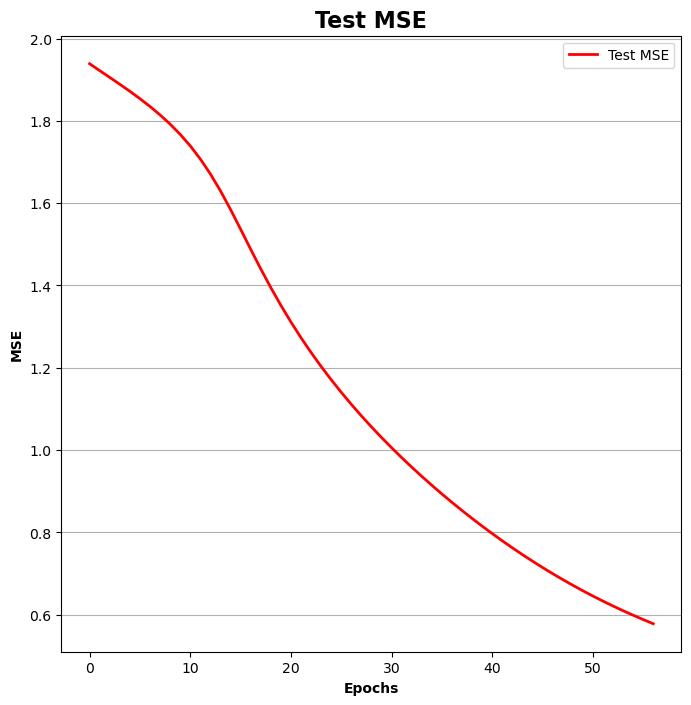

In [1780]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(mse_list, label = "Test MSE", c = "r", linewidth = 2)
plt.grid(axis = "y")
plt.xlabel("Epochs", fontweight = "bold")
plt.ylabel("MSE", fontweight = "bold")
plt.title("Test MSE", fontweight = "bold", fontsize = 16)
plt.legend()
plt.show()

# Inverse transform

In [1781]:
# To NumPy array
best_pred = np.array(best_pred)
best_actual_test = np.array(best_actual_test)
best_actual_train = np.array(best_actual_train)

# Inverse scaled predicted close stock price
close_pred = target_scaler.inverse_transform(best_pred.reshape(-1, 1))
close_actual_test = target_scaler.inverse_transform(best_actual_test.reshape(-1, 1))
close_actual_train = target_scaler.inverse_transform(best_actual_train.reshape(-1, 1))

# Create DataFrame from predicted stock prices by recordings since 2017

In [1782]:
# Define days since first recording of 2017
test_time = []
for i in range(0, len(close_actual_test)):
    test_time.append(i + len(close_actual_train))

# Flatten the NumPy arrays to lists
# Actual close price
flat_test_close = []
for item in close_actual_test:
    flat_test_close.append(item)

# Predicted close price
flat_pred = []
for item in close_pred:
    flat_pred.append(item)

# DataFrame of AMZN stock close price history since and predictions since 2017
amzn_stock_test = pd.DataFrame({
    "Days": test_time,
    "Close": flat_test_close,
    "Predicted close": flat_pred
})

# Create DataFrame from actual stock prices by recordings since first record

In [1783]:
# Define days since first record of stock in dataset
train_time = []
for i in range(0, len(close_actual_train) + len(close_actual_test)):
    train_time.append(i)

# Flatten the NumPy array to list
# Close price used to train model
flat_train_close = []
for item in close_actual_train:
    flat_train_close.append(item)

# Combine actual close price from train and test 
flat_train_close.extend(flat_test_close)

# DataFrame of entire AMZN stock close price history 
amzn_stock = pd.DataFrame({
    "Days": train_time,
    "Close": flat_train_close,
})

# Plot predicted closing price versus actual closing price

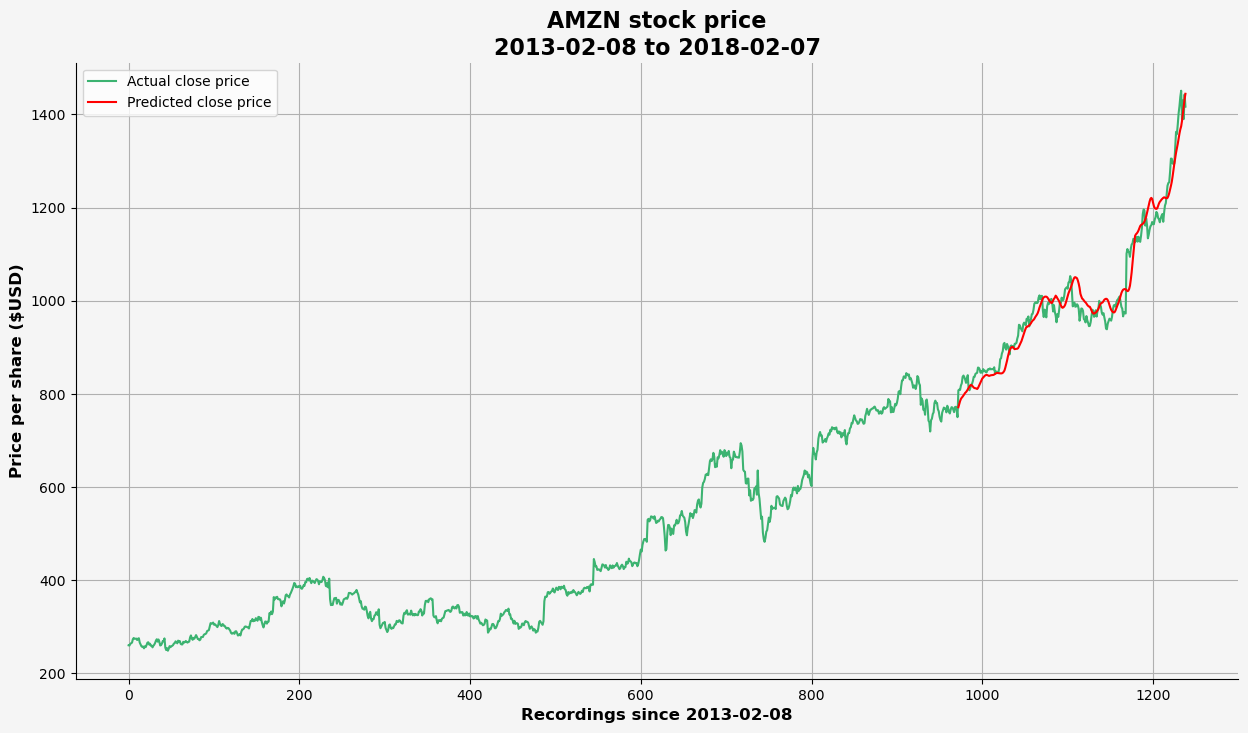

In [1784]:
# Plot
fig, ax = plt.subplots(figsize = (15, 8))
fig.set_facecolor("#F5F5F5")
ax.set_facecolor("#F5F5F5")

# Plots
plt.plot(amzn_stock["Days"], amzn_stock["Close"], c = "#3CB371", label = "Actual close price")
plt.plot(amzn_stock_test["Days"], amzn_stock_test["Predicted close"], c = "r", label = "Predicted close price", linestyle = "solid")

# Grid
plt.grid(True)

#Title
plt.title(
    f'AMZN stock price\n2013-02-08 to 2018-02-07',
    fontweight = "bold",
    fontsize = 16
    )

# Labels
plt.xlabel(
    "Recordings since 2013-02-08",
    fontweight = "bold",
    fontsize = 12
    )
plt.ylabel(
    "Price per share ($USD)",
    fontweight = "bold",
    fontsize = 12
    )

# Spines
ax.spines["top"].set_color(None)
ax.spines["right"].set_color(None)
plt.legend(loc = "upper left")
fig.savefig(fname="predicted_stock_price.png")
plt.show()